## Q1: Describe and analyze the dataset

The project's goal is to predict a font's name using images and machine learning / deep learning alogorithms; we are to pick two appropiate models and copare the accuracy obtained by both.

The dataset is divided into a training and test set.
it consists of 20x20 black and white images, each image is flattened to create 400 comlums and 196189 rows (total images number), each line contains a label (Y) which is the font's name and a corresponding flattened image, so we need to reshape the data so we can get the image in its normal shape and train our model accordingly.

My first choice is to work with the CNN model (The Convolutional Neural Network); it is a subtype of Neural Networks that is mainly used for applications in image and speech recognition. Its built-in convolutional layer reduces the high dimensionality of images without losing its information. That is why CNNs are especially suited for this use case.

the second model chosen is the DNN(Deep Neural Network).
DNNs are able to solve far more complex problems through a wide range of architectures other than simple feed-forward, fully connected networks.


### step 1: importing needed libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score # accuracy calculation
import torch.nn.functional as F 
import torch
import torchvision                     # torch dependencies 
from torch import nn
from torch.utils.data import DataLoader, Dataset
device= torch.device('cuda')  # cuda to enable GPU usage

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/font-recognition/Font_Recognition/train.csv
/kaggle/input/font-recognition/Font_Recognition/test.csv


### step 2: importing the font dataset provided for the project

In [2]:
data = pd.read_csv(r'../input/font-recognition/Font_Recognition/train.csv')
data.head()
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196189 entries, 0 to 196188
Columns: 412 entries, font to r19c19
dtypes: float64(2), int64(408), object(2)
memory usage: 616.7+ MB


,m_label,strength,italic,orientation,m_top,m_left,originalH,originalW,h,w,...,r19c10,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19
count,196189.000000,196189.000000,196189.000000,196189.0,196189.000000,196189.000000,196189.000000,196189.000000,196189.0,196189.0,...,196189.000000,196189.000000,196189.000000,196189.000000,196189.000000,196189.000000,196189.000000,196189.000000,196189.000000,196189.000000
mean,3994.343995,0.508884,0.356936,0.0,29.047714,17.008614,39.989123,31.426451,20.0,20.0,...,136.321466,130.911820,125.098201,119.449872,111.627089,102.818099,94.694596,83.969066,72.330579,62.979571
std,10872.388726,0.144255,0.479097,0.0,20.492335,11.303211,16.989373,14.743560,0.0,0.0,...,111.556486,110.621319,108.719261,109.143397,109.659166,109.728665,109.072616,104.864716,102.181670,97.146504
min,0.000000,0.400000,0.000000,0.0,0.000000,0.000000,1.000000,1.000000,20.0,20.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,56.000000,0.400000,0.000000,0.0,0.000000,0.000000,26.000000,22.000000,20.0,20.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,245.000000,0.400000,0.000000,0.0,34.000000,22.000000,45.000000,32.000000,20.0,20.0,...,152.000000,141.000000,128.000000,116.000000,89.000000,48.000000,8.000000,1.000000,1.000000,1.000000
75%,1496.000000,0.700000,1.000000,0.0,41.000000,24.000000,51.000000,40.000000,20.0,20.0,...,255.000000,255.000000,255.000000,255.000000,255.000000,253.000000,233.000000,186.000000,156.000000,125.000000
max,65532.000000,0.700000,1.000000,0.0,106.000000,95.000000,121.000000,180.000000,20.0,20.0,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


In [3]:
test_data = pd.read_csv(r'../input/font-recognition/Font_Recognition/test.csv')
test_data.info()
test_data.head()
test_data.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48824 entries, 0 to 48823
Columns: 412 entries, font to r19c19
dtypes: float64(2), int64(408), object(2)
memory usage: 153.5+ MB


,m_label,strength,italic,orientation,m_top,m_left,originalH,originalW,h,w,...,r19c10,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19
count,48824.000000,48824.000000,48824.000000,48824.0,48824.000000,48824.000000,48824.000000,48824.000000,48824.0,48824.0,...,48824.000000,48824.000000,48824.000000,48824.000000,48824.000000,48824.000000,48824.000000,48824.000000,48824.000000,48824.000000
mean,3970.215099,0.509053,0.360642,0.0,29.224541,17.076909,40.002806,31.468294,20.0,20.0,...,136.264542,130.695314,124.409532,118.304932,110.056427,101.777097,93.298296,82.252253,70.558946,61.598722
std,10779.917386,0.144304,0.480192,0.0,20.461567,11.278017,16.967867,14.730040,0.0,0.0,...,111.616990,110.757747,108.882208,109.033761,109.510577,109.669045,108.692177,104.288068,101.482725,96.431573
min,0.000000,0.400000,0.000000,0.0,0.000000,0.000000,1.000000,1.000000,20.0,20.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,56.000000,0.400000,0.000000,0.0,0.000000,0.000000,26.000000,22.000000,20.0,20.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,245.000000,0.400000,0.000000,0.0,35.000000,22.000000,45.000000,32.000000,20.0,20.0,...,151.000000,141.000000,128.000000,113.000000,83.000000,42.000000,4.000000,1.000000,1.000000,1.000000
75%,1488.250000,0.700000,1.000000,0.0,41.000000,24.000000,51.000000,40.000000,20.0,20.0,...,255.000000,255.000000,255.000000,255.000000,255.000000,249.000000,227.000000,180.000000,151.000000,120.000000
max,65532.000000,0.700000,1.000000,0.0,103.000000,96.000000,119.000000,175.000000,20.0,20.0,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


### step 3: preparing and selecting the data features and labels

In [4]:
data.loc[:,'fontVariant']

0         FRANKLIN GOTHIC MEDIUM COND
1                              GADUGI
2                             scanned
3                             CALIBRI
4                          BAUHAUS 93
                     ...             
196184                BODONI MT BLACK
196185                        scanned
196186                        scanned
196187                        scanned
196188               FRENCH SCRIPT MT
Name: fontVariant, Length: 196189, dtype: object

In [5]:
x=data[data.fontVariant=='scanned']

In [6]:
print(x)

              font fontVariant  m_label  strength  italic  orientation  m_top  \
2       CREDITCARD     scanned       52       0.4       0          0.0      0   
11      CREDITCARD     scanned       48       0.4       0          0.0      0   
16      CREDITCARD     scanned       48       0.4       0          0.0      0   
17            E13B     scanned       53       0.4       0          0.0      0   
18            E13B     scanned       55       0.4       0          0.0      0   
...            ...         ...      ...       ...     ...          ...    ...   
196180        E13B     scanned       52       0.4       0          0.0      0   
196182  CREDITCARD     scanned       52       0.4       0          0.0      0   
196185        E13B     scanned       57       0.4       0          0.0      0   
196186        E13B     scanned       49       0.4       0          0.0      0   
196187        E13B     scanned       50       0.4       0          0.0      0   

        m_left  originalH  

In [7]:
X_train = data.iloc[:,:12]

In [8]:
X_train

,font,fontVariant,m_label,strength,italic,orientation,m_top,m_left,originalH,originalW,h,w
0,FRANKLIN,FRANKLIN GOTHIC MEDIUM COND,197,0.7,1,0.0,24,20,60,44,20,20
1,GADUGI,GADUGI,5560,0.7,0,0.0,37,23,47,47,20,20
2,CREDITCARD,scanned,52,0.4,0,0.0,0,0,50,32,20,20
3,CALIBRI,CALIBRI,8216,0.4,0,0.0,38,25,17,10,20,20
4,BAUHAUS,BAUHAUS 93,8220,0.7,1,0.0,34,36,19,36,20,20
...,...,...,...,...,...,...,...,...,...,...,...,...
196184,BODONI,BODONI MT BLACK,245,0.4,1,0.0,38,21,44,39,20,20
196185,E13B,scanned,57,0.4,0,0.0,0,0,15,8,20,20
196186,E13B,scanned,49,0.4,0,0.0,0,0,16,8,20,20
196187,E13B,scanned,50,0.4,0,0.0,0,0,15,8,20,20


In [9]:
X_train = data.iloc[:,12:]  #training features
Ytr = data['fontVariant']          #training labels

X_test = test_data.iloc[:,12:]   #test features
Yte = test_data['fontVariant']          #test labels

Y = pd.concat([Ytr,Yte])     # concat the labels for proper factorisation 
Y = Y.factorize()[0]         # factorizing the labels

Y_train = Y[:X_train.shape[0]] # factorized train labels
Y_test = Y[X_train.shape[0]:] # factorized test labels

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)


(196189, 400)
(196189,)
(48824, 400)
(48824,)


### Q2: Detail the distribution of the dataset labels

<AxesSubplot:title={'center':'Training labels distribution'}>

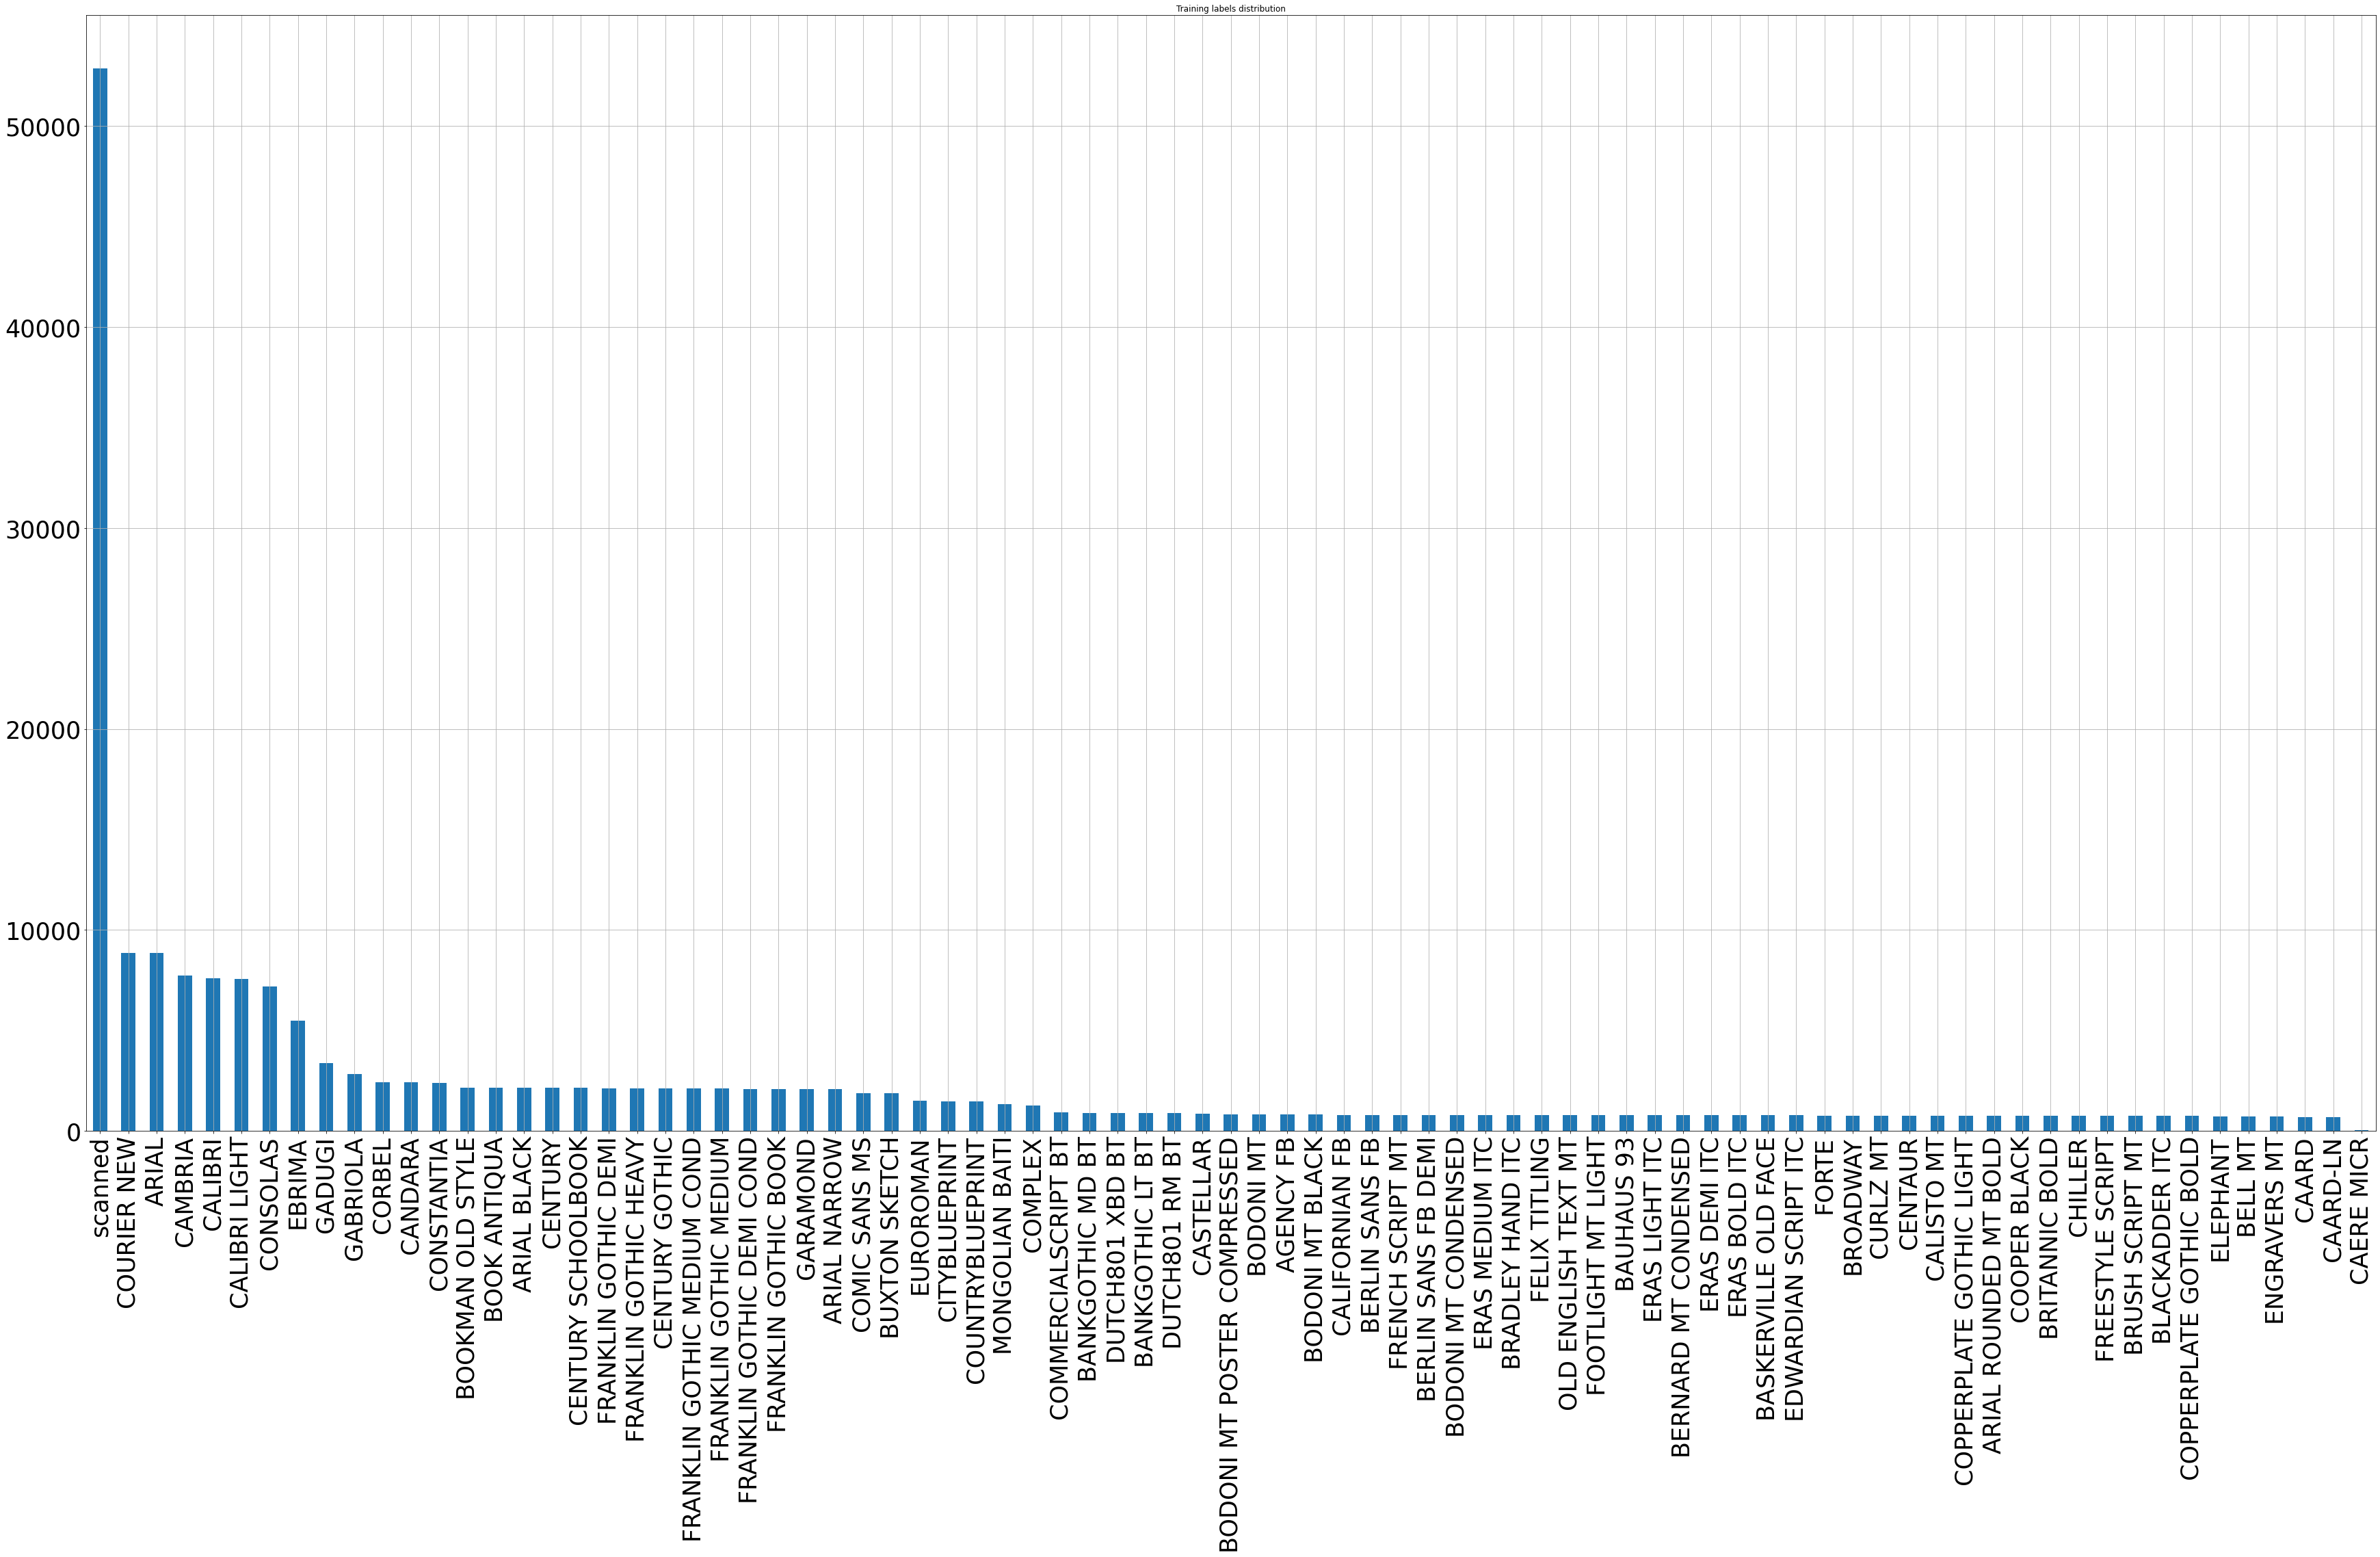

In [10]:
Ytr.value_counts().plot(kind='bar',figsize=(60,30),title="Training labels distribution",fontsize=35,grid=True)

### step 4: Creating the class DatasetFONT 

This class inherits from the pre-coded Dataset class from torch, this way it's easier for us to manage, arrange, call or reshape the whole data, a split-type parameter is included to let the user choose which part he needs.

In [11]:
#df['equal_or_lower_than_4?'] = df['set_of_numbers'].apply(lambda x: 'True' if x <= 4 else 'False')
data2 = data

#font_train2 = font_train.assign(isScanned=lambda x: 0 if x.fontVariant != 2 else 1)

#font_train2['isScanned'] = font_train2['fontVariant'].apply(lambda x: 0 if x != 'scanned' else 1)
#font_train2.info()
#font_train2.head()

isScanned = data['fontVariant'].apply(lambda x: 0 if x != 'scanned' else 1).to_numpy()
print(isScanned)

[0 0 1 ... 1 1 0]


In [12]:
class DatasetFONT(Dataset):
    
    def __init__(self, split_type):
        if split_type == 1:
            self.X = X_train.to_numpy().reshape([-1, 1, 20, 20])/255 #reshaping and normalizing the data 
            self.Y = Y_train
            self.X = torch.from_numpy(self.X).to(device)
            self.Y = torch.from_numpy(self.Y).to(device)
        elif split_type == 2:
            self.X = X_test.to_numpy().reshape([-1, 1, 20, 20])/255  
            self.Y = Y_test
            self.X = torch.from_numpy(self.X).to(device)
            self.Y = torch.from_numpy(self.Y).to(device)
        else:
            print("second parameter is wrong, choose 1 for TrainSet, 2 for TestSet")
            
            
        
    def __len__(self):
        return self.X.size()[0]
    
    def __getitem__(self, index):
        # convert numpy ndarray shape to tensor in PyTorch --> (C, H, W)
        image =  self.X[index]
        label = self.Y[index]      
        return image, label

### testing the dataset class and checking the size and type

In [13]:
train_dataset = DatasetFONT(1)
test_dataset = DatasetFONT(2)
img, lab = train_dataset.__getitem__(0)
print(img.size())
print(type(img))
type(train_dataset)

torch.Size([1, 20, 20])
<class 'torch.Tensor'>


__main__.DatasetFONT

### step 5: creating a loader and configuring the batch size

The Dataloader from torch libraries lets us create itterable data batches so we can train our model with the mini-batch technique for more accurate results.

As we can see the batch consists of 32 images shown in the grid allongside their 32 corresponding labels on top of the grid.

images shape on batch size =  torch.Size([64, 1, 20, 20])
labels shape on batch size =  torch.Size([64])


/opt/conda/lib/python3.7/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


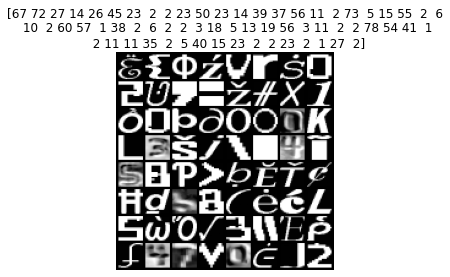

In [14]:
batch_size=64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
train_iter = iter(train_loader)
images, labels = train_iter.next()
print('images shape on batch size = ', images.size())
print('labels shape on batch size = ', labels.size())
grid = torchvision.utils.make_grid(images.cpu())
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.cpu().numpy());

## Question 3 - Describe and propose two different ML models to predict if a font was scanned or not. Create a model to solve this task

### step 6: Defining the CNN model and its layers

This class defines the architecture of the model, its depth, its width and  its activation functions of each layer for the forward pass, this returns the result of our model's prediction.

In [15]:
#CNN Model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding='same')  
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding='same')  
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding='same')
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding='same')
        self.fc1 = nn.Linear(5*5*1024, 10*1024)
        self.fc2 = nn.Linear(10*1024, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256,60)


    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x),2))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = x.view(-1,5*5*1024 ) #flattening
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        x_soft = F.softmax(x, dim=1)
        return x, x_soft

### Configuring the model to run on GPU, the optimizer, the loss function and the number of epochs

I selected 30 epochs and lr=0.0005 after training the model, checking its behaviour and tunning its architecture / hyperparameters.  

In [16]:
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_fn = nn.CrossEntropyLoss()
epochs = 30

###  Defining a function to test our model's accuracy

This function will be called in the main training loop so it can itter on the test_loader and check our model's precision on the test data.

In [17]:
def test_accuracy():
    test_acc=0
    for batch_test, (x_test, y_test) in enumerate(test_loader):
        _, y_pred_test = model(x_test.float())
        test_acc += accuracy_score(y_test.cpu().numpy(), np.argmax(y_pred_test.cpu().detach().numpy(), axis=1))
    return test_acc/batch_test

## step 7: Training the model (main training loop)

In [18]:
# actual training (with batch)
for epoch in range(1, epochs+1):
    loss = 0
    for batch, (x_train, y_train) in enumerate(train_loader):
        y_pred_train, _ = model(x_train.float())
        loss_train = loss_fn(y_pred_train, y_train)
        loss += loss_train.item()
        # Zero gradients
        optimizer.zero_grad()
        loss_train.backward() # Gradients
        optimizer.step() # Update
    accuracy = test_accuracy()
    print("Epoch # %d, train_loss: %s , test accuracy: %s" %(epoch, loss/batch, accuracy))

/usr/local/src/pytorch/aten/src/ATen/native/cuda/Loss.cu:257: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [5,0,0] Assertion `t >= 0 && t < n_classes` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Loss.cu:257: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [19,0,0] Assertion `t >= 0 && t < n_classes` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Loss.cu:257: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [21,0,0] Assertion `t >= 0 && t < n_classes` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Loss.cu:257: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [26,0,0] Assertion `t >= 0 && t < n_classes` failed.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

### defining a function to save the model 

In [ ]:
def save_model(name):
    checkpoint = {'model': Model(),
      'state_dict': model.state_dict(),
      'optimizer' : optimizer.state_dict()}
    torch.save(checkpoint,name)

In [ ]:
save_model("CNN_Font-pred8.pth")